In [31]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123) 

## Dataset

In [32]:
#Load dataset
iris = datasets.load_iris()

In [33]:
sample_idx = [0, 1, 50, 51, 100]
df = pd.DataFrame(iris.data[sample_idx], columns=iris.feature_names)
df['target'] = iris.target[sample_idx]
df['target_names'] = df.target.apply(lambda x: iris.target_names[x])
print(df)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                7.0               3.2                4.7               1.4   
3                6.4               3.2                4.5               1.5   
4                6.3               3.3                6.0               2.5   

   target target_names  
0       0       setosa  
1       0       setosa  
2       1   versicolor  
3       1   versicolor  
4       2    virginica  


In [34]:
X = iris.data
y = iris.target

# Split dataset into training set and test set
X, X_test, y, y_test = train_test_split(X, y, test_size=0.8) # 70% training and 30% test

In [35]:
print(f"{len(X)} samples in training set, {len(X_test)} samples in test set.")

30 samples in training set, 120 samples in test set.


## Fitting the RF

In [36]:
clf = RandomForestClassifier(max_depth=2, n_estimators=100, random_state=0)
clf.fit(X, y)
y_test_hat = clf.predict(X_test)

In [37]:
estimators_ = clf.estimators_
predictions = []
probabilities = []
for x_test in X_test:
    sample_probabilities = []
    for i, estimator_ in enumerate(estimators_):
        clf.estimators_ = [estimator_]
        leaf_index = clf.apply([x_test])
        probability = estimator_.tree_.value[leaf_index][0][0][0]
        sample_probabilities.append(probability)
    probabilities.append(sample_probabilities)
probabilities = np.array(probabilities)

## Calculating uncertainty

In [38]:
def calc_entropy(probs):
    H = 0
    for prob in probs:
        if prob != 0:
            H -= prob * np.log2(prob)
    return H

In [39]:
def calc_entropies(sample_probabilities):
    # total entropy
    mean_probs = np.mean(sample_probabilities, axis=0)
    total_entropy = calc_entropy(mean_probs)
    # conditional entropy
    conditional_entropy = 0
    for prob in sample_probabilities:
        conditional_entropy += calc_entropy(prob)
    conditional_entropy /= len(probabilities)
    # mutual information
    mutual_information = total_entropy - conditional_entropy
    return total_entropy, conditional_entropy, mutual_information

In [40]:
tot_unc_X_test = []
al_unc_X_test = []
ep_unc_X_test = []
for sample_probabilities in probabilities:
    total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty = calc_entropies(sample_probabilities)
    tot_unc_X_test.append(total_uncertainty)
    al_unc_X_test.append(aleatoric_uncertainty)
    ep_unc_X_test.append(epistemic_uncertainty)
tot_unc_X_test = np.array(tot_unc_X_test)
al_unc_X_test = np.array(al_unc_X_test)
ep_unc_X_test = np.array(ep_unc_X_test)

## Accuracy-Rejection curves

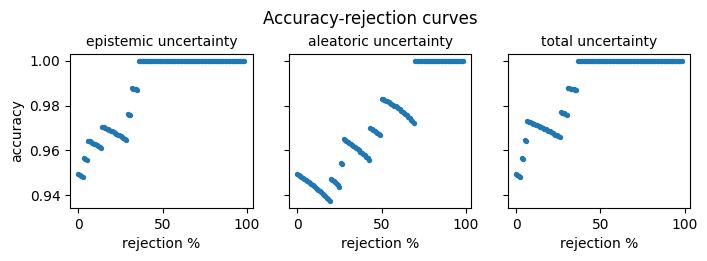

In [41]:
metric = accuracy_score


def accuracy_rejection(y_test_orig, y_test_hat_orig, uncs, uncertainties, filename):
    fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharey=True, sharex=True)
    fig.suptitle(f'Accuracy-rejection curves', fontsize=12, y=1.1)
    for unc_nr, (unc, unc_type) in enumerate(zip(uncs, uncertainties)):
        sorted_idx = np.argsort(unc)
        unc = unc[sorted_idx]
        y_test = y_test_orig[sorted_idx]
        y_test_hat = y_test_hat_orig[sorted_idx]
        scores = []
        shares = []
        for i in range(len(y_test)-1):
            score = metric(y_test[:-i-1], y_test_hat[:-i-1])
            scores.append(score)
            shares.append(100 * i / len(y_test))

        ax[unc_nr].set_title(f"{unc_type} uncertainty", fontsize=10)
        if unc_nr == 0:
            ax[unc_nr].set_ylabel("accuracy")
        ax[unc_nr].set_xlabel("rejection %")
        ax[unc_nr].scatter(shares, scores, label="", s=8)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
uncs = [ep_unc_X_test, al_unc_X_test, tot_unc_X_test]
uncertainties = ["epistemic", "aleatoric", "total"]
filename= "RF_acc_rej.png"
accuracy_rejection(y_test, y_test_hat, uncs, uncertainties, filename)

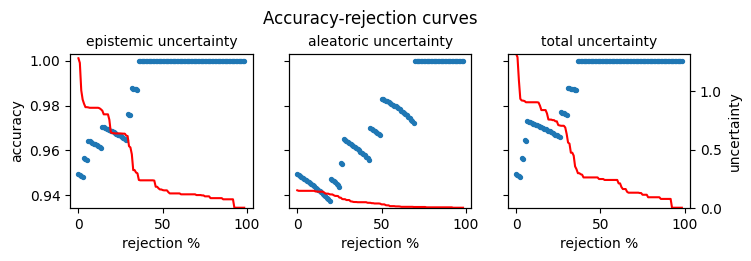

In [42]:
def accuracy_rejection_unc(y_test_orig, y_test_hat_orig, uncs, uncertainties, filename):
    fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharey=True, sharex=True)
    fig.suptitle(f'Accuracy-rejection curves', fontsize=12, y=1.1)
    min_unc = min(min(uncs[0]), min(uncs[1]))
    max_unc = max(uncs[2])
    for unc_nr, (unc, unc_type) in enumerate(zip(uncs, uncertainties)):
        sorted_idx = np.argsort(unc)
        unc = unc[sorted_idx]
        y_test = y_test_orig[sorted_idx]
        y_test_hat = y_test_hat_orig[sorted_idx]
        scores = []
        shares = []
        for i in range(len(y_test)-1):
            score = metric(y_test[:-i-1], y_test_hat[:-i-1])
            scores.append(score)
            shares.append(100 * i / len(y_test))

        ax[unc_nr].set_title(f"{unc_type} uncertainty", fontsize=10)
        if unc_nr == 0:
            ax[unc_nr].set_ylabel("accuracy")
        ax[unc_nr].set_xlabel("rejection %")
        ax[unc_nr].scatter(shares, scores, label="", s=8)

        ax2 = ax[unc_nr].twinx()
        if unc_nr != 2:
            ax2.set_yticks([])  # Disable y-ticks for the second y-axis for the first two plots
        else:
            ax2.set_ylabel("uncertainty")  # Only set y-label for the third plot
        ax2.set_ylim(min_unc, max_unc) 
        ax2.plot(shares, np.flip(unc[:-1]), color='red', label="uncertainty")

    plt.savefig(filename, bbox_inches='tight')
    plt.show()
uncs = [ep_unc_X_test, al_unc_X_test, tot_unc_X_test]
uncertainties = ["epistemic", "aleatoric", "total"]
filename= "RF_acc_rej.png"
accuracy_rejection_unc(y_test, y_test_hat, uncs, uncertainties, filename)

## Exploring trees in the forest

DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=209652396)


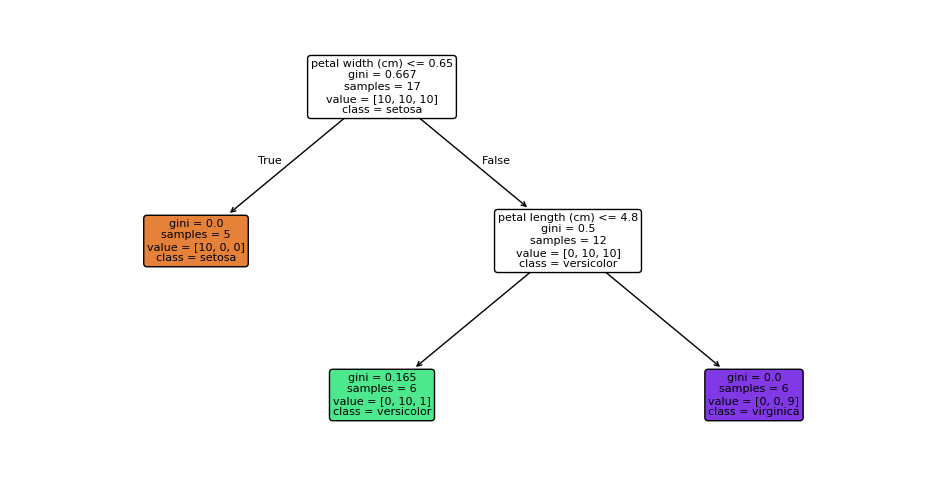

DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=398764591)


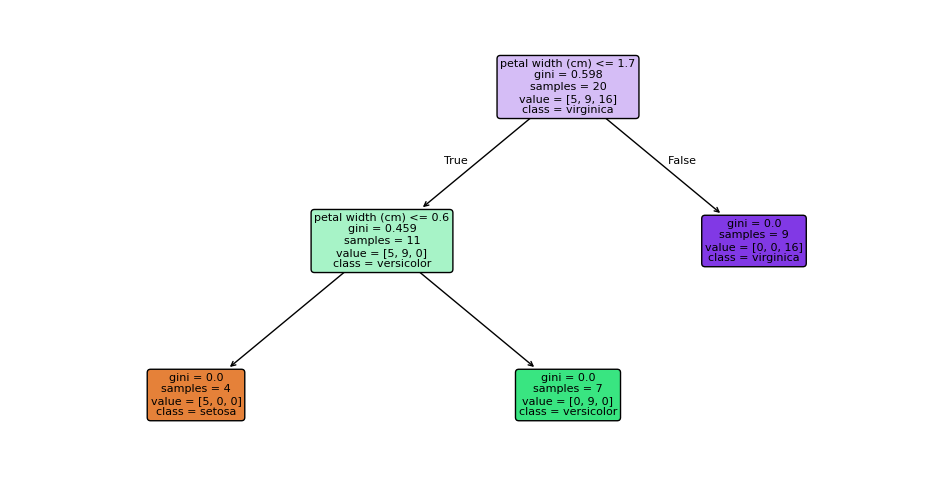

DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=924231285)


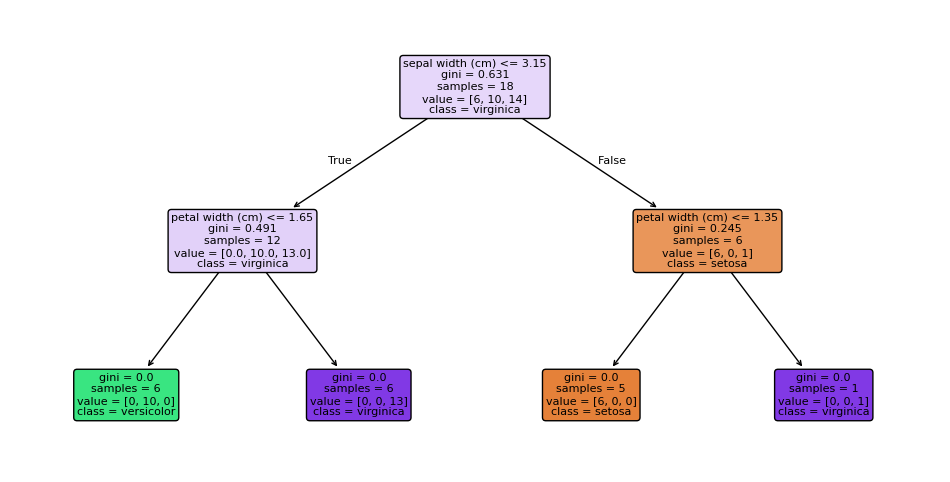

In [45]:
from sklearn import tree
from matplotlib import pyplot as plt

tree_idx = [0, 1]
classes = iris.target_names
features = iris.feature_names
#classes = ["0", "1"]
#features = ["A", "B", "C", "D"]
filename = "RF_trees"

for i, estimator_ in enumerate(estimators_[:3]):
#for i in tree_idx:
#   estimator_ = estimators_[i]
    print(estimator_)
    plt.figure(figsize=(12,6))
    tree.plot_tree(estimator_,
                   feature_names=features,
                   class_names=classes,
                   fontsize=8, 
                   filled=True, 
                   rounded=True)
    plt.savefig(f"{filename}_{i}.png", bbox_inches='tight')
    plt.show()

## Explore one sample

In [46]:
sample_nr = 5
df = pd.DataFrame([X_test[sample_nr]], columns=iris.feature_names)
df['target'] = y_test[sample_nr]
df['target_name'] = df.target.apply(lambda x: iris.target_names[x])
df['prediction'] = y_test_hat[sample_nr]
df['predicted_name'] = df.target.apply(lambda x: iris.target_names[x])
print(df)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                6.0               3.0                4.8               1.8   

   target target_name  prediction predicted_name  
0       2   virginica           2      virginica  


In [47]:
print(X_test[sample_nr])

[6.  3.  4.8 1.8]


In [48]:
print(y_test_hat[sample_nr])

2


In [49]:
mean_prob = np.mean(probabilities[sample_nr], axis=0)
print(f"mean probabilities: {mean_prob}")

mean probabilities: [0.         0.21072633 0.78927367]


In [50]:
total_entropy = calc_entropy(mean_prob)
print(f"total entropy: {total_entropy}")

total entropy: 0.7428688105811394


In [51]:
conditional_entropy = 0
cond_eps = []
for prob in probabilities[sample_nr]:
    conditional_entropy += calc_entropy(prob)
    cond_eps.append(calc_entropy(prob))
conditional_entropy /= len(probabilities[sample_nr])
print(f"aleatoric entropy: {conditional_entropy}")

aleatoric entropy: 0.1217675651654689


In [52]:
df = pd.DataFrame(probabilities[sample_nr][:5], columns=["p_setosa", "p_versi", "p_virgi"])
df["condit_entropy"] = cond_eps[:5]
print(df)

   p_setosa   p_versi   p_virgi  condit_entropy
0       0.0  0.000000  1.000000        0.000000
1       0.0  0.000000  1.000000        0.000000
2       0.0  0.000000  1.000000        0.000000
3       0.0  0.952381  0.047619        0.276195
4       0.0  0.000000  1.000000        0.000000


In [53]:
print(f"epistemic entropy: {total_entropy - conditional_entropy}")

epistemic entropy: 0.6211012454156705


In [54]:
print(probabilities[sample_nr,:3,:])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
